In [2]:
import dataset
import torch
import matplotlib.pyplot as plt

from utils import DepthNorm
from losses import ssim, depth_loss
from model import UNet
device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
print(f"Now using device: {device}")

print("Loading data ...")
train_loader, val_loader = dataset.createTrainLoader("./data.zip", samples=2000, batch_size=4)
test_loader = dataset.createTestLoader("./data.zip", batch_size=1)

print("DataLoaders now ready ...")
model = UNet().to(torch.device(device))

Now using device: cuda
Loading data ...
Loading dataset zip file...Loaded (50688).
Training set size: 1600  Validation set size: 400
Loading dataset zip file...Loaded (50688).
DataLoaders now ready ...


In [3]:
checkpoint = torch.load('checkpoints/epoch_250.pt')
model.load_state_dict(checkpoint['model_state_dict'])
l1_criterion = torch.nn.L1Loss()

In [4]:
# model.eval()
# with torch.no_grad():
#     running_test_loss = 0
#     for batch_idx, batch in enumerate(test_loader):
#         image = torch.Tensor(batch["image"]).to(device)
#         depth = torch.Tensor(batch["depth"]).to(device=device)

#         normalized_depth = DepthNorm(depth)

#         pred = model(image)

#         # calculating the losses
#         l1_loss = l1_criterion(pred, normalized_depth)

#         ssim_loss = torch.clamp(
#             (1 - ssim(pred, normalized_depth, 1000.0 / 10.0)) * 0.5,
#             min=0,
#             max=1,
#         )

#         gradient_loss = depth_loss(normalized_depth, pred, device=device)

#         net_loss = (
#             (1.0 * ssim_loss)
#             + (1.0 * torch.mean(gradient_loss))
#             + (0.1 * torch.mean(l1_loss))
#         )
    
#         cpu_loss = net_loss.cpu().detach().numpy()
#         running_test_loss += cpu_loss
            

#         batch = next(iter(test_loader))
#         image_x = torch.Tensor(batch["image"]).to(device)
#         depth_y = torch.Tensor(batch["depth"]).to(device=device)
#         for i in range(3):
#             out = model(image_x[i].unsqueeze(0))
#             normalized_depth = DepthNorm(depth_y[i])

#             pred = model(image_x[i].unsqueeze(0))

#             # calculating the losses
#             l1_loss = l1_criterion(pred, normalized_depth)

#             ssim_loss = torch.clamp(
#                 (1 - ssim(pred, normalized_depth, 1000.0 / 10.0)) * 0.5,
#                 min=0,
#                 max=1,
#             )

#             gradient_loss = depth_loss(normalized_depth.unsqueeze(0), pred, device=device)

#             net_loss = (
#                 (1.0 * ssim_loss)
#                 + (1.0 * torch.mean(gradient_loss))
#                 + (0.1 * torch.mean(l1_loss))
#             )
#             cpu_loss = net_loss.cpu().detach().numpy()
#             fig,ax = plt.subplots(1,3,figsize=(16,8))
#             ax[0].imshow(image_x[i].permute(1,2,0).cpu())
#             ax[1].imshow(depth_y[i][0].cpu())
#             ax[2].imshow(DepthNorm(out.cpu()[0][0]))
#             ax[2].set_title(f"loss:{net_loss}")

In [14]:
import pandas as pd
def compute_errors(gt, pred, epsilon=1e-6):
    # Ensure non-zero and non-negative ground truth values
    gt = torch.clamp(gt, min=epsilon)
    pred = torch.clamp(pred, min=epsilon)  # Also ensure predictions are positive

    # thresh = torch.max((gt / pred), (pred / gt))
    # a1 = (thresh < 1.25).float().mean()
    # a2 = (thresh < (1.25 ** 2)).float().mean()
    # a3 = (thresh < (1.25 ** 3)).float().mean()
    
    
    d1 = pred / gt
    d2 = gt / pred
    
    max_d1_d2 = torch.max(d1, d2)
    
    zero = torch.zeros(pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3])
    one = torch.ones(pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3])
    bit_mat = torch.where(max_d1_d2.cpu() < 1.25, one, zero)
    count_mat = torch.sum(bit_mat, (1, 2, 3))
    threshold_mat = count_mat / (pred.shape[2] * pred.shape[3])
    a1 = threshold_mat.mean()
    
    zero = torch.zeros(pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3])
    one = torch.ones(pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3])
    bit_mat = torch.where(max_d1_d2.cpu() < (1.25 ** 2), one, zero)
    count_mat = torch.sum(bit_mat, (1, 2, 3))
    threshold_mat = count_mat / (pred.shape[2] * pred.shape[3])
    a2 = threshold_mat.mean()
    
    zero = torch.zeros(pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3])
    one = torch.ones(pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3])
    bit_mat = torch.where(max_d1_d2.cpu() < (1.25 ** 3), one, zero)
    count_mat = torch.sum(bit_mat, (1, 2, 3))
    threshold_mat = count_mat / (pred.shape[2] * pred.shape[3])
    a3 = threshold_mat.mean()
    

    rmse = torch.sqrt(((gt - pred) ** 2).mean())
    rmse_log = torch.sqrt(((torch.log(gt) - torch.log(pred)) ** 2).mean())

    abs_rel = torch.mean(torch.abs(gt - pred) / gt)
    sq_rel = torch.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

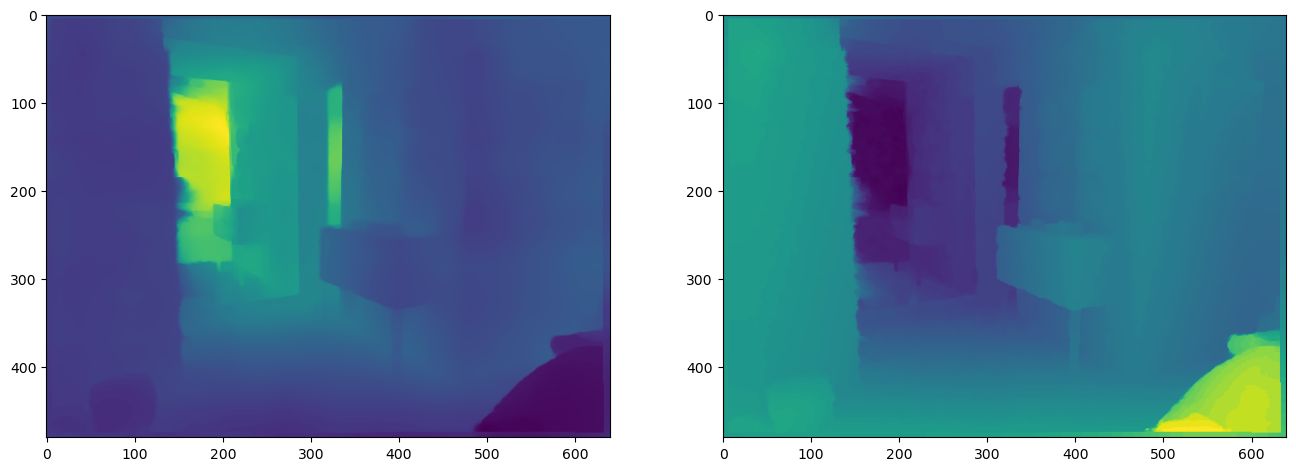

In [6]:
model.eval()
with torch.no_grad():
    running_test_loss = 0
    for batch_idx, batch in enumerate(test_loader):
        image = torch.Tensor(batch["image"]).to(device)
        depth = torch.Tensor(batch["depth"]).to(device=device)

        normalized_depth = DepthNorm(depth)

        pred = model(image)
        
        out = DepthNorm(pred)
        
        error_pred = out.cpu().detach().squeeze(0)
        error_depth = normalized_depth.cpu().detach().squeeze(0)
        
        fig,ax = plt.subplots(1,2,figsize=(16,8))
        ax[0].imshow(error_pred.permute(1,2,0))
        ax[1].imshow(error_depth.permute(1,2,0))
        
        abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3 = compute_errors(depth.permute(1,2,0), pred.permute(1,2,0))
        totals["abs_rel"] += abs_rel
        totals["sq_rel"] += sq_rel
        totals["rmse"] += rmse
        totals["rmse_log"] += rmse_log
        totals["a1"] += a1
        totals["a2"] += a2
        break

In [ ]:
for key, value in totals.items():
    totals[key] = value / len(train_loader)

In [ ]:
totals

{'abs_rel': tensor(121.1369),
 'sq_rel': tensor(46269.3789),
 'rmse': tensor(354.7513),
 'rmse_log': tensor(5.2986),
 'a1': tensor(0.),
 'a2': tensor(0.),
 'a3': 0.0}

In [16]:
from tqdm import tqdm

def test(model, dataloader, criterion, device, epoch, train=False):
    model.eval()  
    running_loss = 0.0
    errors = []
    l1_loss = torch.nn.L1Loss()
    with torch.no_grad():  
        # for images, depths in tqdm(dataloader):
        for samples in tqdm(dataloader):
            images, targets = samples['image'], samples['depth']
            images, targets = images.to(device), targets.to(device)
            # Forward pass
            predictions = model(images)
            errors.append(compute_errors(targets, predictions))
    epoch_loss = running_loss / len(dataloader.dataset)
    # Convert list of tuples to a list of tensors
    error_tensors = [torch.tensor(e).to(device) for e in errors]
    # Stack the list of tensors along a new dimension
    error_stack = torch.stack(error_tensors, dim=0)
    # Compute the mean of each error metric across all batches
    mean_errors = error_stack.mean(0).cpu().numpy()
    # Index into mean_errors to get each metric
    abs_rel = mean_errors[0]
    sq_rel = mean_errors[1]
    rmse = mean_errors[2]
    rmse_log = mean_errors[3]
    a1 = mean_errors[4]
    a2 = mean_errors[5]
    a3 = mean_errors[6]
    print(f"Abs Rel: {abs_rel:.3f}, Sq Rel: {sq_rel:.3f}, RMSE: {rmse:.3f}, RMSE log {rmse_log:.3f}, d1: {a1:.3f}, d2: {a2:.3f}, d3: {a3:.3f}")
    
test(model, test_loader, torch.nn.L1Loss(), "cuda", 1)

100%|██████████| 500/500 [00:16<00:00, 30.01it/s]


Abs Rel: 0.977, Sq Rel: 286.220, RMSE: 313.760, RMSE log 4.239, d1: 0.000, d2: 0.000, d3: 0.000
